In [ ]:
# Imports and Data
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import math
# for converting data to tensors before feeding into network
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from google.colab.patches import cv2_imshow
from google.colab import drive

from tqdm import tqdm

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# YOU CAN MANUALLY ADD THESE IMAGES TO THE RUN TIME AFTER DOWNLOADING THEM FROM GITHUB
image1 = "validation_img1.jpeg" # real signature
image2 = "validation_img2.jpeg" # forged signature

In [ ]:
def display_image(image):
    cv2_imshow(image)

def load_image(image_path):
    src = cv2.imread(image_path)
    #print(src)
    return src

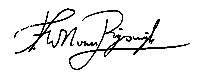

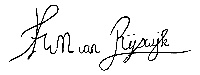

In [ ]:
img1 = load_image(image1)
img2 = load_image(image2)

display_image(load_image(image1))
display_image(load_image(image2))


# Network Module

In [ ]:
class SiameseNetwork(nn.Module):
    '''
    Siamese Network module
    '''
    # self.contrastive_loss = 0.5*(1-Y)*(Dw**2) + 0.5*Y*(max(0,m-Dw))**2
    # self.Dw = lambda x1,x2: math.sqrt(math.pow(Gw(x1)-Gw(x2),2))
    kernel_size = 10

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=7),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 128, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
        )
        self.fc1 = nn.Sequential(
            nn.Linear(256*2*18, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),  # Add dropout for regularization
            nn.Linear(4096, 1)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        # output = output.view(output.size()[0], -1)
        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

    def evaluate(self, dataloader, labels):
        # Switch the network to evaluation mode
        self.eval()

        correct_pairs = 0
        total_pairs = 0

        # Iterate over the data loader
        for i, data in enumerate(dataloader.dataset[0]):
            img0, img1 = data

            label = labels[i]
            img0, img1 = img0.cuda(), img1.cuda()

            # do a prediction
            output1,output2 = network.forward(img0.unsqueeze(0),img1.unsqueeze(0))
            # Calculate the Euclidean distance between the outputs
            distance = F.pairwise_distance(output1, output2)

            # Check if the distance is less than a threshold for similar pairs
            # or greater than a threshold for dissimilar pairs
            # Adjust the threshold as needed
            threshold = 5

            prediction = torch.max(distance).item() < threshold
            print(f"Distance between images: {torch.max(distance).item()} (compared to a threshold of {threshold})")
            # print(torch.max(distance).item(), label)
            if label == int(prediction):
                correct_pairs+=1
            total_pairs += 1

        accuracy = 1.0*correct_pairs / total_pairs
        # print(f"Accuracy is: {accuracy}")
        return accuracy

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    """

    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label.item()) * torch.pow(euclidean_distance, 2) +
                                      (label.item()) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive


# Load the trained Model

In [ ]:
def pair(img1, img2):
    '''
    Pairs a genuine signature with a forged signature for the siamese network
    '''
    paired_imgs = torch.stack([img1, img2])
    return paired_imgs


# Enter Path to best_model.pth from input

## We tried to see if it allows you to enter path manually on the side like you can for images and csvs, but it appears to not work

## So just add the path of weights to Drive and then type in the path. Apologies for any inconvience

In [ ]:
network = SiameseNetwork().cuda()
load = True

# This was the only
starting_weights = input("Enter the Path for Trained Weights: ")
if load:
  print(f"Loading the weights from {starting_weights} ...")
  network.load_state_dict(torch.load(starting_weights))
  print("Successfully loaded the model checkpoint!")

# loading in the validation sample
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # normalization of pixel values
])

img1 = transform(img1)
img2 = transform(img2)

data = [pair(img1, img2)]
data_tensor = torch.stack(data)
dataset = TensorDataset(data_tensor)
val_loader = DataLoader(dataset, batch_size=32, shuffle=True)
val_labels = [1, 0]
acc = network.evaluate(val_loader, val_labels)

# Runs one sample! It was incorrect!
print(f'\nValidation Accuracy Achieved: {acc}')

Enter the Path for Trained Weights/content/drive/MyDrive/Handwriting Recognition/best_model.pth
Loading the weights from /content/drive/MyDrive/Handwriting Recognition/best_model.pth ...
Successfully loaded the model checkpoint!

Validation Accuracy Achieved: 0.0
